<img src="scvi_more_accurate.png" width="600">

In [1]:

# various import statements
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import broadcast_shape
from pyro.optim import MultiStepLR
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO, Trace_ELBO, TraceMeanField_ELBO
from pyro.contrib.examples.scanvi_data import get_data
from pyro import poutine 
from torch.optim import Adam



import scanpy as sc

import torch.utils.data as data_utils

from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm import tqdm

pyro.enable_validation(True)

In [2]:
### to use kl-annealing enclose the latent parameters with poutine.scale 


In [3]:

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'


### util functions

In [4]:
# Splits a tensor in half along the final dimension
def split_in_half(t):
    """
    taken from pyro tutorial scanVI
    """

    return t.reshape(t.shape[:-1] + (2, -1)).unbind(-2)

    

# Helper for making fully-connected neural networks
def make_fc(dims):
    
    """
    take from pyro tutorial creates eg. usage 
    latent_dims = 10
    n_input = num_genes
    hidden_dims = [128, 128]
    
    dims = [latent_dims] + hidden_dims + [2 * num_genes]
    returns : 
            Sequential(
                      (0): Linear(in_features=10, out_features=128, bias=True)
                      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                      (2): ReLU()
                      (3): Linear(in_features=128, out_features=128, bias=True)
                      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                      (5): ReLU()
                      (6): Linear(in_features=128, out_features=43864, bias=True)
                      (7): BatchNorm1d(43864, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                    )

    """
    
    layers = []
    for in_dim, out_dim in zip(dims, dims[1:]):
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.ReLU())
    return nn.Sequential(*layers[:-1])  # Exclude final ReLU non-linearity



### nn modules

In [5]:
class z_decoder(nn.Module):
    
    """
    decoder which maps the latent space to the parameters of the distribution
    """
    
    def __init__(self, gene_likelihood, n_input, n_output, n_layers, n_hidden , dropout, apply_nonlinearity ):
        
        super(z_decoder, self).__init__()
        
        self.final_non_linearity = nn.Softmax(dim = -1)
        self.gene_likelihood  = gene_likelihood
        self.apply_nonlinearity = apply_nonlinearity
        
        if self.gene_likelihood == "zinb":
            self.core_net = make_fc([n_input] + [n_hidden]*(n_layers-1) + [n_hidden])
            self.mu_net = nn.Linear(n_hidden, n_output)
            self.gate_net = nn.Linear(n_hidden, n_output)
        else:
            self.net = make_fc([n_input] + [n_hidden]*n_layers + [n_output])
            
        
        
    def forward(self, x_n, s_n):
        
        inp = torch.hstack([x_n, s_n[:, None]])
        
        
        if self.gene_likelihood == "zinb":
            x = self.core_net(inp)
            gate_logits = self.gate_net(x)
            mu = self.mu_net(x)
            
        else:
            mu = self.net(x)
            
        if self.apply_nonlinearity:
            mu = self.final_non_linearity(mu) 
            
        if self.gene_likelihood == "zinb":
            return mu, gate_logits
        else:
            return mu    

    
    
class z_encoder(nn.Module):
    """
    encoder which maps the input space to the latent code generating the data 
    """
    
    def __init__(self, n_input, n_output, n_layers, n_hidden , dropout ):
        
        super(z_encoder, self).__init__()
        self.net = make_fc([n_input] + [n_hidden]*n_layers + [n_output])
        
        
    
    
    def forward(self, x_n, s_n):
        
        
        inp_count_log1p = torch.log(1+x_n)
        
        inp = torch.hstack([inp_count_log1p, s_n[:, None]])
        
        
        net_out = self.net(inp)
        
        
        z_code = net_out[..., :-2]
        l_code = net_out[..., -2:]
        
        z_mu, z_log_var = split_in_half(z_code)
        l_mean, l_log_var = split_in_half(l_code)
        
        z_scale = F.softplus(z_log_var)
        l_scale = F.softplus(l_log_var)
        
        
        return z_mu, z_scale, l_mean, l_scale
    

In [6]:
USE_CUDA = True

In [17]:

class scVI_laplace(nn.Module):
    
    """
    has a very basic construction really 
    model, guide and the observation model
    
    """
    
    
    def __init__(self, 
                 gene_likelihood, 
                 latent_dims, 
                 num_genes, 
                 n_layers, 
                 hidden_dim, 
                 dropout_rate, 
                 l_mean_prior, 
                 l_scale_prior, 
                 batch_size , 
                 scale_factor, 
                 use_cuda = USE_CUDA):
        
        
        super().__init__()
        
        

        
            
        self.use_cuda = use_cuda
        self.latent_dims = latent_dims
        self.num_genes = num_genes
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.l_mean_prior = l_mean_prior
        self.l_scale_prior = l_scale_prior
        self.batch_size = batch_size
        self.scale_factor = scale_factor
        self.gene_likelihood = gene_likelihood
        self.epsilon = 0.006
        
        self.z_enc = z_encoder(1+num_genes, 2+2*latent_dims, n_layers, hidden_dim, dropout_rate).cpu()
        
        if self.gene_likelihood == "zinb":
            self.z_dec = z_decoder(self.gene_likelihood,1+latent_dims, num_genes, n_layers, hidden_dim, dropout_rate,apply_nonlinearity = True).cpu()
        else:
            self.z_dec = z_decoder(self.gene_likelihood,1+latent_dims, num_genes, n_layers, hidden_dim, dropout_rate,apply_nonlinearity = True).cpu()

        self.prior_mu = torch.zeros(self.latent_dims).cpu()
        self.prior_scale = torch.ones(self.latent_dims).cpu()
        self.nice_one = torch.ones((self.batch_size, 1 ) ).cpu()

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()

    def model(self, x_n, s_n):
        """
        define the generative process of the data
        takes in the latent code and generates the data 

        data = z_latent + [batch_idx]

        """
        
        pyro.module("decoder", self.z_dec)
        
        
        if self.gene_likelihood in ["zinb", "nb"]:
            θ = pyro.param("total_counts", 5.*torch.ones(num_genes).cpu(), constraint = constraints.greater_than(0.01))

        with pyro.plate("generative", x_n.shape[0]), poutine.scale(scale=self.scale_factor):
            
            z_n = pyro.sample("latent_code", dist.Laplace(self.prior_mu, 0.5*self.prior_scale).to_event(1) ) 
            
            
            l_scale =  self.l_scale_prior*self.nice_one
            l_mean = self.l_mean_prior*self.nice_one
            l_n = pyro.sample("library_scaling", dist.LogNormal(l_mean, l_scale).to_event(1) )
                    
            if self.gene_likelihood == "zinb":
                mu, gate_logits = self.z_dec(z_n, s_n.squeeze())
                nb_logits = (l_n * mu + self.epsilon).log() - (θ + self.epsilon).log()# + 1e-3
                #print (nb_logits > )
                dist_obs = dist.ZeroInflatedNegativeBinomial(total_count = θ, logits = nb_logits, gate_logits = gate_logits, validate_args=False).to_event(1)

            elif self.gene_likelihood == "nb":
                mu= self.z_dec(z_n, s_n)                
                nb_logits = (l_n * mu + self.epsilon).log() - (θ + self.epsilon).log()
                dist_obs = dist.NegativeBinomial(total_count = θ, logits = nb_logits ).to_event(1)
                
            elif self.gene_likelihood == "poisson":
                λ = l_n*self.z_dec(z_n, s_n) + self.epsilon
                dist_obs = dist.Poisson(λ).to_event(1)

            pyro.sample("obs", dist_obs, obs = x_n)


    def guide(self, x_n, s_n):

        pyro.module("encoder", self.z_enc)
        
        
        with pyro.plate("generative", x_n.shape[0]), poutine.scale(scale=self.scale_factor):

            z_mu, z_scale, l_mu, l_scale = self.z_enc(x_n, s_n)
            z_n = pyro.sample("latent_code", dist.Laplace(z_mu, 0.5*z_scale).to_event(1)  )     
            l_n = pyro.sample("library_scaling", dist.LogNormal(l_mu, l_scale).to_event(1) )

    
    

## read in the data 

In [8]:
adata = sc.read_h5ad("tabula_muris_processed.h5ad")

In [9]:
## get the l_mean and l_scale priors
cnt = adata.X.toarray().sum(1)
cnt = np.log1p(cnt)
l_mean_prior, l_scale_prior = cnt.mean(), cnt.std()
l_mean_prior, l_scale_prior

(5.689011, 0.28705895)

In [10]:
num_genes = 2000

In [11]:
batch_size = 128
scale_factor = 1/(batch_size * num_genes)


In [18]:
scvi_model = scVI_laplace(gene_likelihood = "zinb",
                  latent_dims = 10, 
                  num_genes = num_genes, 
                  n_layers = 2, 
                  hidden_dim = 128, 
                  dropout_rate = .1, 
                  l_mean_prior = l_mean_prior,
                  l_scale_prior = l_scale_prior, 
                  batch_size = 128, 
                  scale_factor = scale_factor, 
                  use_cuda=False)


In [19]:
x_n = torch.tensor(adata.layers["counts"].toarray())
s_n = adata.obs["tech"].to_numpy()
s_n_l, s_n = np.unique(s_n, return_inverse=True)
s_n = torch.tensor(s_n)

In [20]:

scheduler = MultiStepLR({'optimizer': Adam,
                         'optim_args': {'lr': 0.006},
                         'gamma': 0.2, 'milestones': [20]})
loss = TraceMeanField_ELBO()

svi = SVI(scvi_model.model, scvi_model.guide, scheduler, loss)

In [25]:
def train(svi, train_loader, use_cuda=USE_CUDA):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x_n, s_n  in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if len(x_n) != 128:
            pass
        else:
            if use_cuda:

                x_n = x_n.cpu()
                s_n = s_n.cpu()
            else:
                x_n = x_n[0]
            # do ELBO gradient and accumulate loss
            epoch_loss += svi.step(x_n, s_n)
        scheduler.step()
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [26]:


    
traindataset = data_utils.TensorDataset(x_n.cpu(), s_n.cpu())
train_loader = data_utils.DataLoader(traindataset, batch_size=128, shuffle=True )


In [27]:
NUM_EPOCHS = 400
# clear param store
pyro.clear_param_store()



train_elbo = []
# training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.5f" % (epoch, total_epoch_loss_train))

    

  0%|▎                                                                                                                     | 1/400 [00:01<11:09,  1.68s/it]

[epoch 000]  average training loss: 1.38344


  0%|▌                                                                                                                     | 2/400 [00:03<10:40,  1.61s/it]

[epoch 001]  average training loss: 1.21401


  1%|▉                                                                                                                     | 3/400 [00:04<10:25,  1.58s/it]

[epoch 002]  average training loss: 1.12217


  1%|█▏                                                                                                                    | 4/400 [00:06<10:07,  1.53s/it]

[epoch 003]  average training loss: 1.06361


  1%|█▍                                                                                                                    | 5/400 [00:07<10:00,  1.52s/it]

[epoch 004]  average training loss: 0.98886


  2%|█▊                                                                                                                    | 6/400 [00:09<10:01,  1.53s/it]

[epoch 005]  average training loss: 0.93441


  2%|██                                                                                                                    | 7/400 [00:10<09:46,  1.49s/it]

[epoch 006]  average training loss: 0.87529


  2%|██▎                                                                                                                   | 8/400 [00:12<09:37,  1.47s/it]

[epoch 007]  average training loss: 0.82407


  2%|██▋                                                                                                                   | 9/400 [00:13<09:18,  1.43s/it]

[epoch 008]  average training loss: 0.77213


  2%|██▉                                                                                                                  | 10/400 [00:14<09:11,  1.42s/it]

[epoch 009]  average training loss: 0.72761


  3%|███▏                                                                                                                 | 11/400 [00:16<09:15,  1.43s/it]

[epoch 010]  average training loss: 0.68303


  3%|███▌                                                                                                                 | 12/400 [00:17<09:10,  1.42s/it]

[epoch 011]  average training loss: 0.64261


  3%|███▊                                                                                                                 | 13/400 [00:19<09:14,  1.43s/it]

[epoch 012]  average training loss: 0.59996


  4%|████                                                                                                                 | 14/400 [00:20<09:15,  1.44s/it]

[epoch 013]  average training loss: 0.56121


  4%|████▍                                                                                                                | 15/400 [00:22<09:37,  1.50s/it]

[epoch 014]  average training loss: 0.52720


  4%|████▋                                                                                                                | 16/400 [00:23<09:58,  1.56s/it]

[epoch 015]  average training loss: 0.49436


  4%|████▉                                                                                                                | 17/400 [00:25<09:36,  1.50s/it]

[epoch 016]  average training loss: 0.46361


  4%|█████▎                                                                                                               | 18/400 [00:27<09:56,  1.56s/it]

[epoch 017]  average training loss: 0.43756


  5%|█████▌                                                                                                               | 19/400 [00:28<09:51,  1.55s/it]

[epoch 018]  average training loss: 0.40299


  5%|█████▊                                                                                                               | 20/400 [00:29<09:29,  1.50s/it]

[epoch 019]  average training loss: 0.37939


  5%|██████▏                                                                                                              | 21/400 [00:31<09:23,  1.49s/it]

[epoch 020]  average training loss: 0.34839


  6%|██████▍                                                                                                              | 22/400 [00:32<09:26,  1.50s/it]

[epoch 021]  average training loss: 0.32864


  6%|██████▋                                                                                                              | 23/400 [00:34<09:21,  1.49s/it]

[epoch 022]  average training loss: 0.30559


  6%|███████                                                                                                              | 24/400 [00:35<09:15,  1.48s/it]

[epoch 023]  average training loss: 0.28496


  6%|███████▎                                                                                                             | 25/400 [00:37<09:10,  1.47s/it]

[epoch 024]  average training loss: 0.26902


  6%|███████▌                                                                                                             | 26/400 [00:38<09:02,  1.45s/it]

[epoch 025]  average training loss: 0.24860


  7%|███████▉                                                                                                             | 27/400 [00:40<08:50,  1.42s/it]

[epoch 026]  average training loss: 0.23420


  7%|████████▏                                                                                                            | 28/400 [00:41<08:54,  1.44s/it]

[epoch 027]  average training loss: 0.21715


  7%|████████▍                                                                                                            | 29/400 [00:42<08:51,  1.43s/it]

[epoch 028]  average training loss: 0.20246


  8%|████████▊                                                                                                            | 30/400 [00:44<09:35,  1.55s/it]

[epoch 029]  average training loss: 0.19010


  8%|█████████                                                                                                            | 31/400 [00:46<09:51,  1.60s/it]

[epoch 030]  average training loss: 0.17764


  8%|█████████▎                                                                                                           | 32/400 [00:47<09:37,  1.57s/it]

[epoch 031]  average training loss: 0.16583


  8%|█████████▋                                                                                                           | 33/400 [00:49<09:20,  1.53s/it]

[epoch 032]  average training loss: 0.15500


  8%|█████████▉                                                                                                           | 34/400 [00:50<09:18,  1.53s/it]

[epoch 033]  average training loss: 0.14587


  9%|██████████▏                                                                                                          | 35/400 [00:52<09:03,  1.49s/it]

[epoch 034]  average training loss: 0.13605


  9%|██████████▌                                                                                                          | 36/400 [00:53<08:54,  1.47s/it]

[epoch 035]  average training loss: 0.12770


  9%|██████████▊                                                                                                          | 37/400 [00:55<08:55,  1.48s/it]

[epoch 036]  average training loss: 0.12040


 10%|███████████                                                                                                          | 38/400 [00:56<08:51,  1.47s/it]

[epoch 037]  average training loss: 0.11248


 10%|███████████▍                                                                                                         | 39/400 [00:58<09:09,  1.52s/it]

[epoch 038]  average training loss: 0.10535


 10%|███████████▋                                                                                                         | 40/400 [00:59<09:08,  1.52s/it]

[epoch 039]  average training loss: 0.09926


 10%|███████████▉                                                                                                         | 41/400 [01:01<09:05,  1.52s/it]

[epoch 040]  average training loss: 0.09504


 10%|████████████▎                                                                                                        | 42/400 [01:02<08:57,  1.50s/it]

[epoch 041]  average training loss: 0.08738


 11%|████████████▌                                                                                                        | 43/400 [01:04<08:53,  1.49s/it]

[epoch 042]  average training loss: 0.08315


 11%|████████████▊                                                                                                        | 44/400 [01:05<08:57,  1.51s/it]

[epoch 043]  average training loss: 0.07845


 11%|█████████████▏                                                                                                       | 45/400 [01:07<09:00,  1.52s/it]

[epoch 044]  average training loss: 0.07456


 12%|█████████████▍                                                                                                       | 46/400 [01:08<08:52,  1.50s/it]

[epoch 045]  average training loss: 0.07065


 12%|█████████████▋                                                                                                       | 47/400 [01:10<09:09,  1.56s/it]

[epoch 046]  average training loss: 0.06649


 12%|██████████████                                                                                                       | 48/400 [01:12<09:17,  1.58s/it]

[epoch 047]  average training loss: 0.06397


 12%|██████████████▎                                                                                                      | 49/400 [01:13<09:07,  1.56s/it]

[epoch 048]  average training loss: 0.06018


 12%|██████████████▋                                                                                                      | 50/400 [01:15<09:01,  1.55s/it]

[epoch 049]  average training loss: 0.05682


 13%|██████████████▉                                                                                                      | 51/400 [01:16<08:59,  1.55s/it]

[epoch 050]  average training loss: 0.05463


 13%|███████████████▏                                                                                                     | 52/400 [01:18<09:07,  1.57s/it]

[epoch 051]  average training loss: 0.05211


 13%|███████████████▌                                                                                                     | 53/400 [01:19<08:57,  1.55s/it]

[epoch 052]  average training loss: 0.04971


 14%|███████████████▊                                                                                                     | 54/400 [01:21<08:49,  1.53s/it]

[epoch 053]  average training loss: 0.04783


 14%|████████████████                                                                                                     | 55/400 [01:22<08:33,  1.49s/it]

[epoch 054]  average training loss: 0.04538


 14%|████████████████▍                                                                                                    | 56/400 [01:24<08:54,  1.56s/it]

[epoch 055]  average training loss: 0.04337


 14%|████████████████▋                                                                                                    | 57/400 [01:25<08:43,  1.53s/it]

[epoch 056]  average training loss: 0.04195


 14%|████████████████▉                                                                                                    | 58/400 [01:27<08:26,  1.48s/it]

[epoch 057]  average training loss: 0.04062


 15%|█████████████████▎                                                                                                   | 59/400 [01:28<08:30,  1.50s/it]

[epoch 058]  average training loss: 0.03882


 15%|█████████████████▌                                                                                                   | 60/400 [01:30<08:32,  1.51s/it]

[epoch 059]  average training loss: 0.03732


 15%|█████████████████▊                                                                                                   | 61/400 [01:31<08:33,  1.51s/it]

[epoch 060]  average training loss: 0.03575


 16%|██████████████████▏                                                                                                  | 62/400 [01:33<08:29,  1.51s/it]

[epoch 061]  average training loss: 0.03410


 16%|██████████████████▍                                                                                                  | 63/400 [01:34<08:29,  1.51s/it]

[epoch 062]  average training loss: 0.03347


 16%|██████████████████▋                                                                                                  | 64/400 [01:36<08:20,  1.49s/it]

[epoch 063]  average training loss: 0.03235


 16%|███████████████████                                                                                                  | 65/400 [01:37<08:26,  1.51s/it]

[epoch 064]  average training loss: 0.03090


 16%|███████████████████▎                                                                                                 | 66/400 [01:39<08:16,  1.49s/it]

[epoch 065]  average training loss: 0.03032


 17%|███████████████████▌                                                                                                 | 67/400 [01:40<08:05,  1.46s/it]

[epoch 066]  average training loss: 0.02976


 17%|███████████████████▉                                                                                                 | 68/400 [01:42<07:58,  1.44s/it]

[epoch 067]  average training loss: 0.02867


 17%|████████████████████▏                                                                                                | 69/400 [01:43<07:47,  1.41s/it]

[epoch 068]  average training loss: 0.02779


 18%|████████████████████▍                                                                                                | 70/400 [01:44<07:41,  1.40s/it]

[epoch 069]  average training loss: 0.02699


 18%|████████████████████▊                                                                                                | 71/400 [01:46<07:37,  1.39s/it]

[epoch 070]  average training loss: 0.02613


 18%|█████████████████████                                                                                                | 72/400 [01:47<07:30,  1.37s/it]

[epoch 071]  average training loss: 0.02538


 18%|█████████████████████▎                                                                                               | 73/400 [01:48<07:30,  1.38s/it]

[epoch 072]  average training loss: 0.02468


 18%|█████████████████████▋                                                                                               | 74/400 [01:50<07:45,  1.43s/it]

[epoch 073]  average training loss: 0.02402


 19%|█████████████████████▉                                                                                               | 75/400 [01:51<07:44,  1.43s/it]

[epoch 074]  average training loss: 0.02290


 19%|██████████████████████▏                                                                                              | 76/400 [01:53<07:51,  1.45s/it]

[epoch 075]  average training loss: 0.02242


 19%|██████████████████████▌                                                                                              | 77/400 [01:54<07:47,  1.45s/it]

[epoch 076]  average training loss: 0.02198


 20%|██████████████████████▊                                                                                              | 78/400 [01:56<07:56,  1.48s/it]

[epoch 077]  average training loss: 0.02146


 20%|███████████████████████                                                                                              | 79/400 [01:57<07:58,  1.49s/it]

[epoch 078]  average training loss: 0.02059


 20%|███████████████████████▍                                                                                             | 80/400 [01:59<07:58,  1.49s/it]

[epoch 079]  average training loss: 0.02053


 20%|███████████████████████▋                                                                                             | 81/400 [02:00<07:51,  1.48s/it]

[epoch 080]  average training loss: 0.02006


 20%|███████████████████████▉                                                                                             | 82/400 [02:02<07:52,  1.48s/it]

[epoch 081]  average training loss: 0.01945


 21%|████████████████████████▎                                                                                            | 83/400 [02:03<07:46,  1.47s/it]

[epoch 082]  average training loss: 0.01905


 21%|████████████████████████▌                                                                                            | 84/400 [02:05<07:43,  1.47s/it]

[epoch 083]  average training loss: 0.01885


 21%|████████████████████████▊                                                                                            | 85/400 [02:06<07:41,  1.47s/it]

[epoch 084]  average training loss: 0.01820


 22%|█████████████████████████▏                                                                                           | 86/400 [02:08<08:01,  1.53s/it]

[epoch 085]  average training loss: 0.01779


 22%|█████████████████████████▍                                                                                           | 87/400 [02:10<08:22,  1.61s/it]

[epoch 086]  average training loss: 0.01752


 22%|█████████████████████████▋                                                                                           | 88/400 [02:11<08:12,  1.58s/it]

[epoch 087]  average training loss: 0.01709


 22%|██████████████████████████                                                                                           | 89/400 [02:13<08:03,  1.56s/it]

[epoch 088]  average training loss: 0.01682


 22%|██████████████████████████▎                                                                                          | 90/400 [02:14<07:58,  1.54s/it]

[epoch 089]  average training loss: 0.01659


 23%|██████████████████████████▌                                                                                          | 91/400 [02:16<07:44,  1.50s/it]

[epoch 090]  average training loss: 0.01629


 23%|██████████████████████████▉                                                                                          | 92/400 [02:17<07:42,  1.50s/it]

[epoch 091]  average training loss: 0.01594


 23%|███████████████████████████▏                                                                                         | 93/400 [02:19<07:36,  1.49s/it]

[epoch 092]  average training loss: 0.01559


 24%|███████████████████████████▍                                                                                         | 94/400 [02:20<07:57,  1.56s/it]

[epoch 093]  average training loss: 0.01533


 24%|███████████████████████████▊                                                                                         | 95/400 [02:22<08:03,  1.58s/it]

[epoch 094]  average training loss: 0.01514


 24%|████████████████████████████                                                                                         | 96/400 [02:23<07:51,  1.55s/it]

[epoch 095]  average training loss: 0.01491


 24%|████████████████████████████▎                                                                                        | 97/400 [02:25<07:47,  1.54s/it]

[epoch 096]  average training loss: 0.01462


 24%|████████████████████████████▋                                                                                        | 98/400 [02:27<07:42,  1.53s/it]

[epoch 097]  average training loss: 0.01434


 25%|████████████████████████████▉                                                                                        | 99/400 [02:28<07:40,  1.53s/it]

[epoch 098]  average training loss: 0.01414


 25%|█████████████████████████████                                                                                       | 100/400 [02:29<07:28,  1.50s/it]

[epoch 099]  average training loss: 0.01403


 25%|█████████████████████████████▎                                                                                      | 101/400 [02:31<07:24,  1.49s/it]

[epoch 100]  average training loss: 0.01373


 26%|█████████████████████████████▌                                                                                      | 102/400 [02:32<07:26,  1.50s/it]

[epoch 101]  average training loss: 0.01352


 26%|█████████████████████████████▊                                                                                      | 103/400 [02:34<07:25,  1.50s/it]

[epoch 102]  average training loss: 0.01334


 26%|██████████████████████████████▏                                                                                     | 104/400 [02:36<07:32,  1.53s/it]

[epoch 103]  average training loss: 0.01316


 26%|██████████████████████████████▍                                                                                     | 105/400 [02:37<07:33,  1.54s/it]

[epoch 104]  average training loss: 0.01300


 26%|██████████████████████████████▋                                                                                     | 106/400 [02:39<07:27,  1.52s/it]

[epoch 105]  average training loss: 0.01278


 27%|███████████████████████████████                                                                                     | 107/400 [02:40<07:24,  1.52s/it]

[epoch 106]  average training loss: 0.01268


 27%|███████████████████████████████▎                                                                                    | 108/400 [02:42<07:17,  1.50s/it]

[epoch 107]  average training loss: 0.01250


 27%|███████████████████████████████▌                                                                                    | 109/400 [02:43<07:17,  1.50s/it]

[epoch 108]  average training loss: 0.01236


 28%|███████████████████████████████▉                                                                                    | 110/400 [02:44<07:08,  1.48s/it]

[epoch 109]  average training loss: 0.01220


 28%|████████████████████████████████▏                                                                                   | 111/400 [02:46<07:13,  1.50s/it]

[epoch 110]  average training loss: 0.01203


 28%|████████████████████████████████▍                                                                                   | 112/400 [02:47<07:08,  1.49s/it]

[epoch 111]  average training loss: 0.01193


 28%|████████████████████████████████▊                                                                                   | 113/400 [02:49<07:07,  1.49s/it]

[epoch 112]  average training loss: 0.01179


 28%|█████████████████████████████████                                                                                   | 114/400 [02:50<07:00,  1.47s/it]

[epoch 113]  average training loss: 0.01167


 29%|█████████████████████████████████▎                                                                                  | 115/400 [02:52<07:00,  1.48s/it]

[epoch 114]  average training loss: 0.01157


 29%|█████████████████████████████████▋                                                                                  | 116/400 [02:53<07:10,  1.52s/it]

[epoch 115]  average training loss: 0.01139


 29%|█████████████████████████████████▉                                                                                  | 117/400 [02:55<07:02,  1.49s/it]

[epoch 116]  average training loss: 0.01136


 30%|██████████████████████████████████▏                                                                                 | 118/400 [02:56<07:02,  1.50s/it]

[epoch 117]  average training loss: 0.01124


 30%|██████████████████████████████████▌                                                                                 | 119/400 [02:58<06:58,  1.49s/it]

[epoch 118]  average training loss: 0.01116


 30%|██████████████████████████████████▊                                                                                 | 120/400 [02:59<06:56,  1.49s/it]

[epoch 119]  average training loss: 0.01096


 30%|███████████████████████████████████                                                                                 | 121/400 [03:01<06:50,  1.47s/it]

[epoch 120]  average training loss: 0.01087


 30%|███████████████████████████████████▍                                                                                | 122/400 [03:02<06:57,  1.50s/it]

[epoch 121]  average training loss: 0.01073


 31%|███████████████████████████████████▋                                                                                | 123/400 [03:04<06:58,  1.51s/it]

[epoch 122]  average training loss: 0.01069


 31%|███████████████████████████████████▉                                                                                | 124/400 [03:05<06:55,  1.51s/it]

[epoch 123]  average training loss: 0.01059


 31%|████████████████████████████████████▎                                                                               | 125/400 [03:07<06:55,  1.51s/it]

[epoch 124]  average training loss: 0.01054


 32%|████████████████████████████████████▌                                                                               | 126/400 [03:08<06:53,  1.51s/it]

[epoch 125]  average training loss: 0.01044


 32%|████████████████████████████████████▊                                                                               | 127/400 [03:10<06:50,  1.50s/it]

[epoch 126]  average training loss: 0.01031


 32%|█████████████████████████████████████                                                                               | 128/400 [03:11<06:50,  1.51s/it]

[epoch 127]  average training loss: 0.01024


 32%|█████████████████████████████████████▍                                                                              | 129/400 [03:13<06:54,  1.53s/it]

[epoch 128]  average training loss: 0.01018


 32%|█████████████████████████████████████▋                                                                              | 130/400 [03:15<06:58,  1.55s/it]

[epoch 129]  average training loss: 0.01007


 33%|█████████████████████████████████████▉                                                                              | 131/400 [03:16<07:15,  1.62s/it]

[epoch 130]  average training loss: 0.01003


 33%|██████████████████████████████████████▎                                                                             | 132/400 [03:18<07:05,  1.59s/it]

[epoch 131]  average training loss: 0.00990


 33%|██████████████████████████████████████▌                                                                             | 133/400 [03:19<06:55,  1.56s/it]

[epoch 132]  average training loss: 0.00987


 34%|██████████████████████████████████████▊                                                                             | 134/400 [03:21<06:43,  1.52s/it]

[epoch 133]  average training loss: 0.00984


 34%|███████████████████████████████████████▏                                                                            | 135/400 [03:22<06:34,  1.49s/it]

[epoch 134]  average training loss: 0.00974


 34%|███████████████████████████████████████▍                                                                            | 136/400 [03:24<06:38,  1.51s/it]

[epoch 135]  average training loss: 0.00968


 34%|███████████████████████████████████████▋                                                                            | 137/400 [03:25<06:34,  1.50s/it]

[epoch 136]  average training loss: 0.00961


 34%|████████████████████████████████████████                                                                            | 138/400 [03:27<06:39,  1.53s/it]

[epoch 137]  average training loss: 0.00953


 35%|████████████████████████████████████████▎                                                                           | 139/400 [03:28<06:35,  1.52s/it]

[epoch 138]  average training loss: 0.00949


 35%|████████████████████████████████████████▌                                                                           | 140/400 [03:30<06:33,  1.51s/it]

[epoch 139]  average training loss: 0.00944


 35%|████████████████████████████████████████▉                                                                           | 141/400 [03:31<06:29,  1.50s/it]

[epoch 140]  average training loss: 0.00939


 36%|█████████████████████████████████████████▏                                                                          | 142/400 [03:33<06:34,  1.53s/it]

[epoch 141]  average training loss: 0.00936


 36%|█████████████████████████████████████████▍                                                                          | 143/400 [03:34<06:27,  1.51s/it]

[epoch 142]  average training loss: 0.00928


 36%|█████████████████████████████████████████▊                                                                          | 144/400 [03:36<06:32,  1.53s/it]

[epoch 143]  average training loss: 0.00923


 36%|██████████████████████████████████████████                                                                          | 145/400 [03:38<06:27,  1.52s/it]

[epoch 144]  average training loss: 0.00918


 36%|██████████████████████████████████████████▎                                                                         | 146/400 [03:39<06:22,  1.50s/it]

[epoch 145]  average training loss: 0.00911


 37%|██████████████████████████████████████████▋                                                                         | 147/400 [03:41<06:30,  1.54s/it]

[epoch 146]  average training loss: 0.00908


 37%|██████████████████████████████████████████▉                                                                         | 148/400 [03:42<06:23,  1.52s/it]

[epoch 147]  average training loss: 0.00904


 37%|███████████████████████████████████████████▏                                                                        | 149/400 [03:44<06:28,  1.55s/it]

[epoch 148]  average training loss: 0.00899


 38%|███████████████████████████████████████████▌                                                                        | 150/400 [03:45<06:31,  1.57s/it]

[epoch 149]  average training loss: 0.00894


 38%|███████████████████████████████████████████▊                                                                        | 151/400 [03:47<06:26,  1.55s/it]

[epoch 150]  average training loss: 0.00888


 38%|████████████████████████████████████████████                                                                        | 152/400 [03:48<06:34,  1.59s/it]

[epoch 151]  average training loss: 0.00886


 38%|████████████████████████████████████████████▎                                                                       | 153/400 [03:50<06:35,  1.60s/it]

[epoch 152]  average training loss: 0.00882


 38%|████████████████████████████████████████████▋                                                                       | 154/400 [03:52<06:38,  1.62s/it]

[epoch 153]  average training loss: 0.00878


 39%|████████████████████████████████████████████▉                                                                       | 155/400 [03:53<06:34,  1.61s/it]

[epoch 154]  average training loss: 0.00876


 39%|█████████████████████████████████████████████▏                                                                      | 156/400 [03:55<06:19,  1.56s/it]

[epoch 155]  average training loss: 0.00870


 39%|█████████████████████████████████████████████▌                                                                      | 157/400 [03:56<06:06,  1.51s/it]

[epoch 156]  average training loss: 0.00865


 40%|█████████████████████████████████████████████▊                                                                      | 158/400 [03:58<06:04,  1.51s/it]

[epoch 157]  average training loss: 0.00864


 40%|██████████████████████████████████████████████                                                                      | 159/400 [03:59<06:01,  1.50s/it]

[epoch 158]  average training loss: 0.00860


 40%|██████████████████████████████████████████████▍                                                                     | 160/400 [04:01<05:54,  1.48s/it]

[epoch 159]  average training loss: 0.00859


 40%|██████████████████████████████████████████████▋                                                                     | 161/400 [04:02<05:51,  1.47s/it]

[epoch 160]  average training loss: 0.00853


 40%|██████████████████████████████████████████████▉                                                                     | 162/400 [04:04<05:50,  1.47s/it]

[epoch 161]  average training loss: 0.00849


 41%|███████████████████████████████████████████████▎                                                                    | 163/400 [04:05<05:50,  1.48s/it]

[epoch 162]  average training loss: 0.00844


 41%|███████████████████████████████████████████████▌                                                                    | 164/400 [04:06<05:46,  1.47s/it]

[epoch 163]  average training loss: 0.00841


 41%|███████████████████████████████████████████████▊                                                                    | 165/400 [04:08<05:43,  1.46s/it]

[epoch 164]  average training loss: 0.00839


 42%|████████████████████████████████████████████████▏                                                                   | 166/400 [04:09<05:32,  1.42s/it]

[epoch 165]  average training loss: 0.00835


 42%|████████████████████████████████████████████████▍                                                                   | 167/400 [04:11<05:25,  1.40s/it]

[epoch 166]  average training loss: 0.00834


 42%|████████████████████████████████████████████████▋                                                                   | 168/400 [04:12<05:28,  1.42s/it]

[epoch 167]  average training loss: 0.00830


 42%|█████████████████████████████████████████████████                                                                   | 169/400 [04:14<05:34,  1.45s/it]

[epoch 168]  average training loss: 0.00828


 42%|█████████████████████████████████████████████████▎                                                                  | 170/400 [04:15<05:35,  1.46s/it]

[epoch 169]  average training loss: 0.00825


 43%|█████████████████████████████████████████████████▌                                                                  | 171/400 [04:17<05:37,  1.48s/it]

[epoch 170]  average training loss: 0.00859


 43%|█████████████████████████████████████████████████▉                                                                  | 172/400 [04:18<05:48,  1.53s/it]

[epoch 171]  average training loss: 0.00831


 43%|██████████████████████████████████████████████████▏                                                                 | 173/400 [04:20<05:50,  1.54s/it]

[epoch 172]  average training loss: 0.00822


 44%|██████████████████████████████████████████████████▍                                                                 | 174/400 [04:21<05:46,  1.53s/it]

[epoch 173]  average training loss: 0.00819


 44%|██████████████████████████████████████████████████▊                                                                 | 175/400 [04:23<05:52,  1.57s/it]

[epoch 174]  average training loss: 0.00814


 44%|███████████████████████████████████████████████████                                                                 | 176/400 [04:25<05:49,  1.56s/it]

[epoch 175]  average training loss: 0.00812


 44%|███████████████████████████████████████████████████▎                                                                | 177/400 [04:26<05:41,  1.53s/it]

[epoch 176]  average training loss: 0.00807


 44%|███████████████████████████████████████████████████▌                                                                | 178/400 [04:27<05:37,  1.52s/it]

[epoch 177]  average training loss: 0.00803


 45%|███████████████████████████████████████████████████▉                                                                | 179/400 [04:29<05:35,  1.52s/it]

[epoch 178]  average training loss: 0.00801


 45%|████████████████████████████████████████████████████▏                                                               | 180/400 [04:31<05:37,  1.54s/it]

[epoch 179]  average training loss: 0.00799


 45%|████████████████████████████████████████████████████▍                                                               | 181/400 [04:32<05:49,  1.60s/it]

[epoch 180]  average training loss: 0.00796


 46%|████████████████████████████████████████████████████▊                                                               | 182/400 [04:34<06:14,  1.72s/it]

[epoch 181]  average training loss: 0.00794


 46%|█████████████████████████████████████████████████████                                                               | 183/400 [04:36<05:52,  1.62s/it]

[epoch 182]  average training loss: 0.00791


 46%|█████████████████████████████████████████████████████▎                                                              | 184/400 [04:37<05:35,  1.55s/it]

[epoch 183]  average training loss: 0.00789


 46%|█████████████████████████████████████████████████████▋                                                              | 185/400 [04:39<05:31,  1.54s/it]

[epoch 184]  average training loss: 0.00790


 46%|█████████████████████████████████████████████████████▉                                                              | 186/400 [04:40<05:28,  1.53s/it]

[epoch 185]  average training loss: 0.00782


 47%|██████████████████████████████████████████████████████▏                                                             | 187/400 [04:42<05:24,  1.53s/it]

[epoch 186]  average training loss: 0.00781


 47%|██████████████████████████████████████████████████████▌                                                             | 188/400 [04:43<05:21,  1.52s/it]

[epoch 187]  average training loss: 0.00776


 47%|██████████████████████████████████████████████████████▊                                                             | 189/400 [04:45<05:17,  1.51s/it]

[epoch 188]  average training loss: 0.00774


 48%|███████████████████████████████████████████████████████                                                             | 190/400 [04:46<05:16,  1.51s/it]

[epoch 189]  average training loss: 0.00773


 48%|███████████████████████████████████████████████████████▍                                                            | 191/400 [04:48<05:20,  1.53s/it]

[epoch 190]  average training loss: 0.00771


 48%|███████████████████████████████████████████████████████▋                                                            | 192/400 [04:49<05:11,  1.50s/it]

[epoch 191]  average training loss: 0.00764


 48%|███████████████████████████████████████████████████████▉                                                            | 193/400 [04:51<05:12,  1.51s/it]

[epoch 192]  average training loss: 0.00764


 48%|████████████████████████████████████████████████████████▎                                                           | 194/400 [04:52<05:11,  1.51s/it]

[epoch 193]  average training loss: 0.00763


 49%|████████████████████████████████████████████████████████▌                                                           | 195/400 [04:54<05:08,  1.51s/it]

[epoch 194]  average training loss: 0.00760


 49%|████████████████████████████████████████████████████████▊                                                           | 196/400 [04:55<05:09,  1.52s/it]

[epoch 195]  average training loss: 0.00756


 49%|█████████████████████████████████████████████████████████▏                                                          | 197/400 [04:57<05:16,  1.56s/it]

[epoch 196]  average training loss: 0.00753


 50%|█████████████████████████████████████████████████████████▍                                                          | 198/400 [04:58<05:15,  1.56s/it]

[epoch 197]  average training loss: 0.00751


 50%|█████████████████████████████████████████████████████████▋                                                          | 199/400 [05:00<05:26,  1.62s/it]

[epoch 198]  average training loss: 0.00751


 50%|██████████████████████████████████████████████████████████                                                          | 200/400 [05:02<05:17,  1.59s/it]

[epoch 199]  average training loss: 0.00748


 50%|██████████████████████████████████████████████████████████▎                                                         | 201/400 [05:03<05:16,  1.59s/it]

[epoch 200]  average training loss: 0.00745


 50%|██████████████████████████████████████████████████████████▌                                                         | 202/400 [05:05<05:10,  1.57s/it]

[epoch 201]  average training loss: 0.00745


 51%|██████████████████████████████████████████████████████████▊                                                         | 203/400 [05:06<05:07,  1.56s/it]

[epoch 202]  average training loss: 0.00770


 51%|███████████████████████████████████████████████████████████▏                                                        | 204/400 [05:08<05:00,  1.54s/it]

[epoch 203]  average training loss: 0.00788


 51%|███████████████████████████████████████████████████████████▍                                                        | 205/400 [05:09<05:01,  1.54s/it]

[epoch 204]  average training loss: 0.00752


 52%|███████████████████████████████████████████████████████████▋                                                        | 206/400 [05:11<04:52,  1.51s/it]

[epoch 205]  average training loss: 0.00743


 52%|████████████████████████████████████████████████████████████                                                        | 207/400 [05:12<04:58,  1.55s/it]

[epoch 206]  average training loss: 0.00739


 52%|████████████████████████████████████████████████████████████▎                                                       | 208/400 [05:14<04:56,  1.54s/it]

[epoch 207]  average training loss: 0.00738


 52%|████████████████████████████████████████████████████████████▌                                                       | 209/400 [05:16<04:51,  1.53s/it]

[epoch 208]  average training loss: 0.00735


 52%|████████████████████████████████████████████████████████████▉                                                       | 210/400 [05:17<04:55,  1.55s/it]

[epoch 209]  average training loss: 0.00730


 53%|█████████████████████████████████████████████████████████████▏                                                      | 211/400 [05:19<04:48,  1.53s/it]

[epoch 210]  average training loss: 0.00729


 53%|█████████████████████████████████████████████████████████████▍                                                      | 212/400 [05:20<04:45,  1.52s/it]

[epoch 211]  average training loss: 0.00727


 53%|█████████████████████████████████████████████████████████████▊                                                      | 213/400 [05:22<04:45,  1.53s/it]

[epoch 212]  average training loss: 0.00722


 54%|██████████████████████████████████████████████████████████████                                                      | 214/400 [05:23<04:43,  1.52s/it]

[epoch 213]  average training loss: 0.00722


 54%|██████████████████████████████████████████████████████████████▎                                                     | 215/400 [05:25<04:43,  1.53s/it]

[epoch 214]  average training loss: 0.00720


 54%|██████████████████████████████████████████████████████████████▋                                                     | 216/400 [05:26<04:43,  1.54s/it]

[epoch 215]  average training loss: 0.00720


 54%|██████████████████████████████████████████████████████████████▉                                                     | 217/400 [05:28<04:42,  1.54s/it]

[epoch 216]  average training loss: 0.00714


 55%|███████████████████████████████████████████████████████████████▏                                                    | 218/400 [05:29<04:40,  1.54s/it]

[epoch 217]  average training loss: 0.00712


 55%|███████████████████████████████████████████████████████████████▌                                                    | 219/400 [05:31<04:36,  1.53s/it]

[epoch 218]  average training loss: 0.00710


 55%|███████████████████████████████████████████████████████████████▊                                                    | 220/400 [05:32<04:31,  1.51s/it]

[epoch 219]  average training loss: 0.00713


 55%|████████████████████████████████████████████████████████████████                                                    | 221/400 [05:34<04:25,  1.48s/it]

[epoch 220]  average training loss: 0.00708


 56%|████████████████████████████████████████████████████████████████▍                                                   | 222/400 [05:35<04:28,  1.51s/it]

[epoch 221]  average training loss: 0.00705


 56%|████████████████████████████████████████████████████████████████▋                                                   | 223/400 [05:37<04:28,  1.52s/it]

[epoch 222]  average training loss: 0.00704


 56%|████████████████████████████████████████████████████████████████▉                                                   | 224/400 [05:38<04:28,  1.52s/it]

[epoch 223]  average training loss: 0.00702


 56%|█████████████████████████████████████████████████████████████████▎                                                  | 225/400 [05:40<04:26,  1.53s/it]

[epoch 224]  average training loss: 0.00701


 56%|█████████████████████████████████████████████████████████████████▌                                                  | 226/400 [05:41<04:24,  1.52s/it]

[epoch 225]  average training loss: 0.00696


 57%|█████████████████████████████████████████████████████████████████▊                                                  | 227/400 [05:43<04:20,  1.51s/it]

[epoch 226]  average training loss: 0.00696


 57%|██████████████████████████████████████████████████████████████████                                                  | 228/400 [05:45<04:25,  1.55s/it]

[epoch 227]  average training loss: 0.00695


 57%|██████████████████████████████████████████████████████████████████▍                                                 | 229/400 [05:46<04:34,  1.61s/it]

[epoch 228]  average training loss: 0.00691


 57%|██████████████████████████████████████████████████████████████████▋                                                 | 230/400 [05:48<04:30,  1.59s/it]

[epoch 229]  average training loss: 0.00690


 58%|██████████████████████████████████████████████████████████████████▉                                                 | 231/400 [05:49<04:27,  1.59s/it]

[epoch 230]  average training loss: 0.00687


 58%|███████████████████████████████████████████████████████████████████▎                                                | 232/400 [05:51<04:23,  1.57s/it]

[epoch 231]  average training loss: 0.00686


 58%|███████████████████████████████████████████████████████████████████▌                                                | 233/400 [05:53<04:24,  1.58s/it]

[epoch 232]  average training loss: 0.00682


 58%|███████████████████████████████████████████████████████████████████▊                                                | 234/400 [05:54<04:18,  1.56s/it]

[epoch 233]  average training loss: 0.00681


 59%|████████████████████████████████████████████████████████████████████▏                                               | 235/400 [05:55<04:12,  1.53s/it]

[epoch 234]  average training loss: 0.00681


 59%|████████████████████████████████████████████████████████████████████▍                                               | 236/400 [05:57<04:07,  1.51s/it]

[epoch 235]  average training loss: 0.00676


 59%|████████████████████████████████████████████████████████████████████▋                                               | 237/400 [05:58<04:05,  1.50s/it]

[epoch 236]  average training loss: 0.00675


 60%|█████████████████████████████████████████████████████████████████████                                               | 238/400 [06:00<04:06,  1.52s/it]

[epoch 237]  average training loss: 0.00674


 60%|█████████████████████████████████████████████████████████████████████▎                                              | 239/400 [06:02<04:04,  1.52s/it]

[epoch 238]  average training loss: 0.00672


 60%|█████████████████████████████████████████████████████████████████████▌                                              | 240/400 [06:03<04:03,  1.52s/it]

[epoch 239]  average training loss: 0.00670


 60%|█████████████████████████████████████████████████████████████████████▉                                              | 241/400 [06:05<04:15,  1.60s/it]

[epoch 240]  average training loss: 0.00667


 60%|██████████████████████████████████████████████████████████████████████▏                                             | 242/400 [06:06<04:12,  1.60s/it]

[epoch 241]  average training loss: 0.00665


 61%|██████████████████████████████████████████████████████████████████████▍                                             | 243/400 [06:08<04:08,  1.58s/it]

[epoch 242]  average training loss: 0.00663


 61%|██████████████████████████████████████████████████████████████████████▊                                             | 244/400 [06:10<04:12,  1.62s/it]

[epoch 243]  average training loss: 0.00660


 61%|███████████████████████████████████████████████████████████████████████                                             | 245/400 [06:11<04:06,  1.59s/it]

[epoch 244]  average training loss: 0.00658


 62%|███████████████████████████████████████████████████████████████████████▎                                            | 246/400 [06:13<04:01,  1.57s/it]

[epoch 245]  average training loss: 0.00655


 62%|███████████████████████████████████████████████████████████████████████▋                                            | 247/400 [06:14<03:56,  1.55s/it]

[epoch 246]  average training loss: 0.00653


 62%|███████████████████████████████████████████████████████████████████████▉                                            | 248/400 [06:16<03:54,  1.54s/it]

[epoch 247]  average training loss: 0.00651


 62%|████████████████████████████████████████████████████████████████████████▏                                           | 249/400 [06:18<04:04,  1.62s/it]

[epoch 248]  average training loss: 0.00649


 62%|████████████████████████████████████████████████████████████████████████▌                                           | 250/400 [06:19<03:59,  1.59s/it]

[epoch 249]  average training loss: 0.00650


 63%|████████████████████████████████████████████████████████████████████████▊                                           | 251/400 [06:21<03:53,  1.57s/it]

[epoch 250]  average training loss: 0.00646


 63%|█████████████████████████████████████████████████████████████████████████                                           | 252/400 [06:22<03:49,  1.55s/it]

[epoch 251]  average training loss: 0.00646


 63%|█████████████████████████████████████████████████████████████████████████▎                                          | 253/400 [06:24<03:44,  1.53s/it]

[epoch 252]  average training loss: 0.00644


 64%|█████████████████████████████████████████████████████████████████████████▋                                          | 254/400 [06:25<03:46,  1.55s/it]

[epoch 253]  average training loss: 0.00645


 64%|█████████████████████████████████████████████████████████████████████████▉                                          | 255/400 [06:27<03:43,  1.54s/it]

[epoch 254]  average training loss: 0.00644


 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 256/400 [06:28<03:40,  1.53s/it]

[epoch 255]  average training loss: 0.00643


 64%|██████████████████████████████████████████████████████████████████████████▌                                         | 257/400 [06:30<03:46,  1.58s/it]

[epoch 256]  average training loss: 0.00643


 64%|██████████████████████████████████████████████████████████████████████████▊                                         | 258/400 [06:32<03:50,  1.62s/it]

[epoch 257]  average training loss: 0.00642


 65%|███████████████████████████████████████████████████████████████████████████                                         | 259/400 [06:33<03:55,  1.67s/it]

[epoch 258]  average training loss: 0.00642


 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 260/400 [06:35<03:46,  1.62s/it]

[epoch 259]  average training loss: 0.00641


 65%|███████████████████████████████████████████████████████████████████████████▋                                        | 261/400 [06:36<03:40,  1.59s/it]

[epoch 260]  average training loss: 0.00640


 66%|███████████████████████████████████████████████████████████████████████████▉                                        | 262/400 [06:38<03:40,  1.60s/it]

[epoch 261]  average training loss: 0.00641


 66%|████████████████████████████████████████████████████████████████████████████▎                                       | 263/400 [06:39<03:32,  1.55s/it]

[epoch 262]  average training loss: 0.00639


 66%|████████████████████████████████████████████████████████████████████████████▌                                       | 264/400 [06:41<03:32,  1.56s/it]

[epoch 263]  average training loss: 0.00638


 66%|████████████████████████████████████████████████████████████████████████████▊                                       | 265/400 [06:43<03:25,  1.52s/it]

[epoch 264]  average training loss: 0.00638


 66%|█████████████████████████████████████████████████████████████████████████████▏                                      | 266/400 [06:44<03:25,  1.53s/it]

[epoch 265]  average training loss: 0.00639


 67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 267/400 [06:46<03:32,  1.60s/it]

[epoch 266]  average training loss: 0.00638


 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 268/400 [06:47<03:29,  1.59s/it]

[epoch 267]  average training loss: 0.00638


 67%|██████████████████████████████████████████████████████████████████████████████                                      | 269/400 [06:49<03:23,  1.55s/it]

[epoch 268]  average training loss: 0.00638


 68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 270/400 [06:50<03:24,  1.58s/it]

[epoch 269]  average training loss: 0.00636


 68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 271/400 [06:52<03:21,  1.56s/it]

[epoch 270]  average training loss: 0.00637


 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 272/400 [06:53<03:14,  1.52s/it]

[epoch 271]  average training loss: 0.00636


 68%|███████████████████████████████████████████████████████████████████████████████▏                                    | 273/400 [06:55<03:07,  1.48s/it]

[epoch 272]  average training loss: 0.00637


 68%|███████████████████████████████████████████████████████████████████████████████▍                                    | 274/400 [06:56<03:06,  1.48s/it]

[epoch 273]  average training loss: 0.00638


 69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 275/400 [06:58<03:05,  1.49s/it]

[epoch 274]  average training loss: 0.00636


 69%|████████████████████████████████████████████████████████████████████████████████                                    | 276/400 [06:59<03:02,  1.47s/it]

[epoch 275]  average training loss: 0.00635


 69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 277/400 [07:01<03:06,  1.51s/it]

[epoch 276]  average training loss: 0.00636


 70%|████████████████████████████████████████████████████████████████████████████████▌                                   | 278/400 [07:02<03:05,  1.52s/it]

[epoch 277]  average training loss: 0.00636


 70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 279/400 [07:04<03:03,  1.51s/it]

[epoch 278]  average training loss: 0.00636


 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 280/400 [07:05<03:01,  1.51s/it]

[epoch 279]  average training loss: 0.00635


 70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 281/400 [07:07<03:00,  1.52s/it]

[epoch 280]  average training loss: 0.00636


 70%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 282/400 [07:08<02:58,  1.52s/it]

[epoch 281]  average training loss: 0.00634


 71%|██████████████████████████████████████████████████████████████████████████████████                                  | 283/400 [07:10<02:58,  1.53s/it]

[epoch 282]  average training loss: 0.00634


 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 284/400 [07:11<02:56,  1.52s/it]

[epoch 283]  average training loss: 0.00636


 71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 285/400 [07:13<02:54,  1.52s/it]

[epoch 284]  average training loss: 0.00635


 72%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 286/400 [07:15<02:57,  1.56s/it]

[epoch 285]  average training loss: 0.00636


 72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 287/400 [07:16<02:56,  1.56s/it]

[epoch 286]  average training loss: 0.00634


 72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 288/400 [07:18<02:59,  1.61s/it]

[epoch 287]  average training loss: 0.00635


 72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 289/400 [07:20<02:59,  1.61s/it]

[epoch 288]  average training loss: 0.00633


 72%|████████████████████████████████████████████████████████████████████████████████████                                | 290/400 [07:21<03:06,  1.69s/it]

[epoch 289]  average training loss: 0.00633


 73%|████████████████████████████████████████████████████████████████████████████████████▍                               | 291/400 [07:23<03:01,  1.66s/it]

[epoch 290]  average training loss: 0.00634


 73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 292/400 [07:24<02:51,  1.59s/it]

[epoch 291]  average training loss: 0.00633


 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 293/400 [07:26<02:50,  1.59s/it]

[epoch 292]  average training loss: 0.00634


 74%|█████████████████████████████████████████████████████████████████████████████████████▎                              | 294/400 [07:28<02:51,  1.62s/it]

[epoch 293]  average training loss: 0.00633


 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 295/400 [07:29<02:48,  1.61s/it]

[epoch 294]  average training loss: 0.00632


 74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 296/400 [07:31<02:41,  1.55s/it]

[epoch 295]  average training loss: 0.00634


 74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 297/400 [07:32<02:40,  1.56s/it]

[epoch 296]  average training loss: 0.00634


 74%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 298/400 [07:34<02:37,  1.55s/it]

[epoch 297]  average training loss: 0.00632


 75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 299/400 [07:35<02:33,  1.52s/it]

[epoch 298]  average training loss: 0.00633


 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 300/400 [07:37<02:32,  1.52s/it]

[epoch 299]  average training loss: 0.00633


 75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 301/400 [07:38<02:28,  1.50s/it]

[epoch 300]  average training loss: 0.00633


 76%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 302/400 [07:40<02:26,  1.49s/it]

[epoch 301]  average training loss: 0.00633


 76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 303/400 [07:41<02:23,  1.48s/it]

[epoch 302]  average training loss: 0.00633


 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 304/400 [07:43<02:22,  1.48s/it]

[epoch 303]  average training loss: 0.00632


 76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 305/400 [07:44<02:23,  1.51s/it]

[epoch 304]  average training loss: 0.00632


 76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 306/400 [07:46<02:21,  1.50s/it]

[epoch 305]  average training loss: 0.00633


 77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 307/400 [07:47<02:21,  1.52s/it]

[epoch 306]  average training loss: 0.00632


 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 308/400 [07:49<02:20,  1.53s/it]

[epoch 307]  average training loss: 0.00633


 77%|█████████████████████████████████████████████████████████████████████████████████████████▌                          | 309/400 [07:51<02:23,  1.58s/it]

[epoch 308]  average training loss: 0.00633


 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 310/400 [07:52<02:21,  1.57s/it]

[epoch 309]  average training loss: 0.00632


 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 311/400 [07:54<02:17,  1.55s/it]

[epoch 310]  average training loss: 0.00632


 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 312/400 [07:55<02:16,  1.56s/it]

[epoch 311]  average training loss: 0.00632


 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 313/400 [07:57<02:19,  1.61s/it]

[epoch 312]  average training loss: 0.00632


 78%|███████████████████████████████████████████████████████████████████████████████████████████                         | 314/400 [07:59<02:20,  1.63s/it]

[epoch 313]  average training loss: 0.00633


 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 315/400 [08:00<02:18,  1.63s/it]

[epoch 314]  average training loss: 0.00631


 79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 316/400 [08:02<02:19,  1.67s/it]

[epoch 315]  average training loss: 0.00632


 79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 317/400 [08:04<02:20,  1.70s/it]

[epoch 316]  average training loss: 0.00632


 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                       | 318/400 [08:05<02:14,  1.64s/it]

[epoch 317]  average training loss: 0.00632


 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 319/400 [08:07<02:11,  1.62s/it]

[epoch 318]  average training loss: 0.00632


 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 320/400 [08:08<02:05,  1.57s/it]

[epoch 319]  average training loss: 0.00631


 80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 321/400 [08:10<01:59,  1.52s/it]

[epoch 320]  average training loss: 0.00632


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 322/400 [08:11<01:58,  1.52s/it]

[epoch 321]  average training loss: 0.00631


 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 323/400 [08:13<01:57,  1.52s/it]

[epoch 322]  average training loss: 0.00633


 81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 324/400 [08:14<01:59,  1.58s/it]

[epoch 323]  average training loss: 0.00631


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 325/400 [08:16<02:00,  1.61s/it]

[epoch 324]  average training loss: 0.00632


 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 326/400 [08:18<02:00,  1.63s/it]

[epoch 325]  average training loss: 0.00632


 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 327/400 [08:19<01:57,  1.62s/it]

[epoch 326]  average training loss: 0.00632


 82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 328/400 [08:21<01:53,  1.58s/it]

[epoch 327]  average training loss: 0.00632


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                    | 329/400 [08:22<01:51,  1.56s/it]

[epoch 328]  average training loss: 0.00631


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 330/400 [08:24<01:50,  1.57s/it]

[epoch 329]  average training loss: 0.00632


 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 331/400 [08:26<01:50,  1.60s/it]

[epoch 330]  average training loss: 0.00631


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 332/400 [08:27<01:46,  1.57s/it]

[epoch 331]  average training loss: 0.00631


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 333/400 [08:29<01:44,  1.57s/it]

[epoch 332]  average training loss: 0.00630


 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 334/400 [08:30<01:43,  1.57s/it]

[epoch 333]  average training loss: 0.00632


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 335/400 [08:32<01:39,  1.54s/it]

[epoch 334]  average training loss: 0.00631


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 336/400 [08:33<01:37,  1.52s/it]

[epoch 335]  average training loss: 0.00631


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 337/400 [08:35<01:36,  1.53s/it]

[epoch 336]  average training loss: 0.00631


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                  | 338/400 [08:36<01:34,  1.52s/it]

[epoch 337]  average training loss: 0.00631


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 339/400 [08:38<01:36,  1.59s/it]

[epoch 338]  average training loss: 0.00632


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 340/400 [08:40<01:35,  1.60s/it]

[epoch 339]  average training loss: 0.00632


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 341/400 [08:41<01:34,  1.60s/it]

[epoch 340]  average training loss: 0.00631


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 342/400 [08:43<01:40,  1.74s/it]

[epoch 341]  average training loss: 0.00630


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 343/400 [08:45<01:36,  1.70s/it]

[epoch 342]  average training loss: 0.00630


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 344/400 [08:46<01:31,  1.64s/it]

[epoch 343]  average training loss: 0.00631


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 345/400 [08:48<01:28,  1.61s/it]

[epoch 344]  average training loss: 0.00630


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 346/400 [08:49<01:26,  1.60s/it]

[epoch 345]  average training loss: 0.00630


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 347/400 [08:51<01:24,  1.59s/it]

[epoch 346]  average training loss: 0.00631


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 348/400 [08:53<01:22,  1.58s/it]

[epoch 347]  average training loss: 0.00630


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 349/400 [08:54<01:24,  1.66s/it]

[epoch 348]  average training loss: 0.00631


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 350/400 [08:56<01:22,  1.66s/it]

[epoch 349]  average training loss: 0.00629


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 351/400 [08:58<01:20,  1.64s/it]

[epoch 350]  average training loss: 0.00630


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 352/400 [08:59<01:16,  1.60s/it]

[epoch 351]  average training loss: 0.00631


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 353/400 [09:01<01:13,  1.55s/it]

[epoch 352]  average training loss: 0.00630


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 354/400 [09:02<01:11,  1.56s/it]

[epoch 353]  average training loss: 0.00631


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 355/400 [09:04<01:09,  1.55s/it]

[epoch 354]  average training loss: 0.00630


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 356/400 [09:05<01:09,  1.57s/it]

[epoch 355]  average training loss: 0.00629


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 357/400 [09:07<01:07,  1.57s/it]

[epoch 356]  average training loss: 0.00631


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 358/400 [09:08<01:04,  1.54s/it]

[epoch 357]  average training loss: 0.00631


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████            | 359/400 [09:10<01:04,  1.57s/it]

[epoch 358]  average training loss: 0.00630


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 360/400 [09:12<01:03,  1.58s/it]

[epoch 359]  average training loss: 0.00630


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 361/400 [09:14<01:05,  1.68s/it]

[epoch 360]  average training loss: 0.00630


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 362/400 [09:15<01:01,  1.63s/it]

[epoch 361]  average training loss: 0.00630


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 363/400 [09:17<00:59,  1.61s/it]

[epoch 362]  average training loss: 0.00631


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 364/400 [09:18<00:58,  1.63s/it]

[epoch 363]  average training loss: 0.00629


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 365/400 [09:20<00:55,  1.59s/it]

[epoch 364]  average training loss: 0.00628


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 366/400 [09:21<00:53,  1.59s/it]

[epoch 365]  average training loss: 0.00630


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 367/400 [09:23<00:53,  1.62s/it]

[epoch 366]  average training loss: 0.00630


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 368/400 [09:25<00:51,  1.61s/it]

[epoch 367]  average training loss: 0.00630


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 369/400 [09:26<00:49,  1.59s/it]

[epoch 368]  average training loss: 0.00631


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 370/400 [09:28<00:47,  1.58s/it]

[epoch 369]  average training loss: 0.00630


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 371/400 [09:30<00:49,  1.71s/it]

[epoch 370]  average training loss: 0.00630


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 372/400 [09:31<00:47,  1.69s/it]

[epoch 371]  average training loss: 0.00631


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 373/400 [09:33<00:44,  1.66s/it]

[epoch 372]  average training loss: 0.00630


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 374/400 [09:35<00:45,  1.76s/it]

[epoch 373]  average training loss: 0.00630


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 375/400 [09:37<00:46,  1.86s/it]

[epoch 374]  average training loss: 0.00630


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 376/400 [09:39<00:44,  1.84s/it]

[epoch 375]  average training loss: 0.00630


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 377/400 [09:41<00:41,  1.82s/it]

[epoch 376]  average training loss: 0.00630


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 378/400 [09:43<00:40,  1.86s/it]

[epoch 377]  average training loss: 0.00629


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 379/400 [09:45<00:39,  1.90s/it]

[epoch 378]  average training loss: 0.00629


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 380/400 [09:46<00:37,  1.88s/it]

[epoch 379]  average training loss: 0.00629


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 381/400 [09:48<00:35,  1.86s/it]

[epoch 380]  average training loss: 0.00629


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 382/400 [09:50<00:32,  1.82s/it]

[epoch 381]  average training loss: 0.00629


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 383/400 [09:52<00:30,  1.78s/it]

[epoch 382]  average training loss: 0.00630


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 384/400 [09:54<00:28,  1.80s/it]

[epoch 383]  average training loss: 0.00629


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 385/400 [09:55<00:26,  1.80s/it]

[epoch 384]  average training loss: 0.00629


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 386/400 [09:57<00:25,  1.80s/it]

[epoch 385]  average training loss: 0.00630


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 387/400 [09:59<00:23,  1.78s/it]

[epoch 386]  average training loss: 0.00629


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 388/400 [10:01<00:21,  1.82s/it]

[epoch 387]  average training loss: 0.00629


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 389/400 [10:03<00:19,  1.81s/it]

[epoch 388]  average training loss: 0.00630


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 390/400 [10:04<00:18,  1.83s/it]

[epoch 389]  average training loss: 0.00630


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 391/400 [10:06<00:16,  1.83s/it]

[epoch 390]  average training loss: 0.00630


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 392/400 [10:08<00:14,  1.76s/it]

[epoch 391]  average training loss: 0.00629


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 393/400 [10:10<00:12,  1.73s/it]

[epoch 392]  average training loss: 0.00630


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 394/400 [10:11<00:10,  1.68s/it]

[epoch 393]  average training loss: 0.00629


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 395/400 [10:13<00:08,  1.70s/it]

[epoch 394]  average training loss: 0.00629


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 396/400 [10:14<00:06,  1.67s/it]

[epoch 395]  average training loss: 0.00628


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 397/400 [10:16<00:04,  1.64s/it]

[epoch 396]  average training loss: 0.00630


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 398/400 [10:18<00:03,  1.77s/it]

[epoch 397]  average training loss: 0.00628


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 399/400 [10:20<00:01,  1.82s/it]

[epoch 398]  average training loss: 0.00630


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [10:22<00:00,  1.56s/it]

[epoch 399]  average training loss: 0.00629


In [28]:
## experiment with different opti

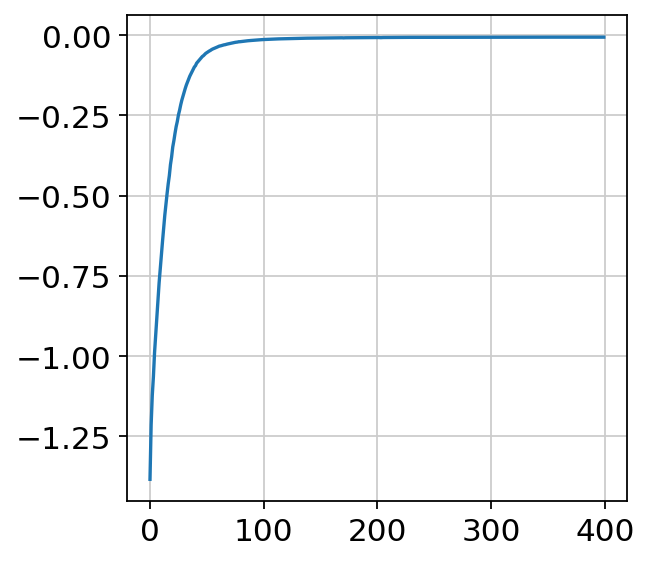

In [29]:
plt.plot(train_elbo)

In [31]:
z_mu, z_log_var, _, _ = scvi_model.z_enc(x_n.cpu(), s_n.cpu())


In [32]:
adata.obsm["X_scVI"] = z_mu.detach().cpu().numpy()
sc.pp.neighbors(adata, use_rep="X_scVI")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [33]:
import scvi

Global seed set to 0
/home/user-dnf/anaconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/user-dnf/anaconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [34]:
#from scvi_.model.utils import mde
sc.pp.neighbors(adata, use_rep="X_scVI")


In [38]:
from scvi.model.utils import mde
import pymde
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

/home/user-dnf/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


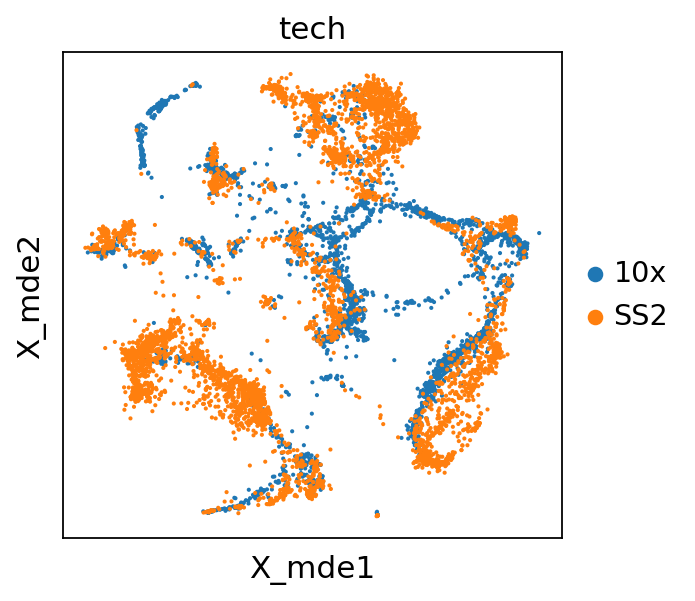

In [39]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["tech"],
    frameon=True,
    ncols=1,
)

/home/user-dnf/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


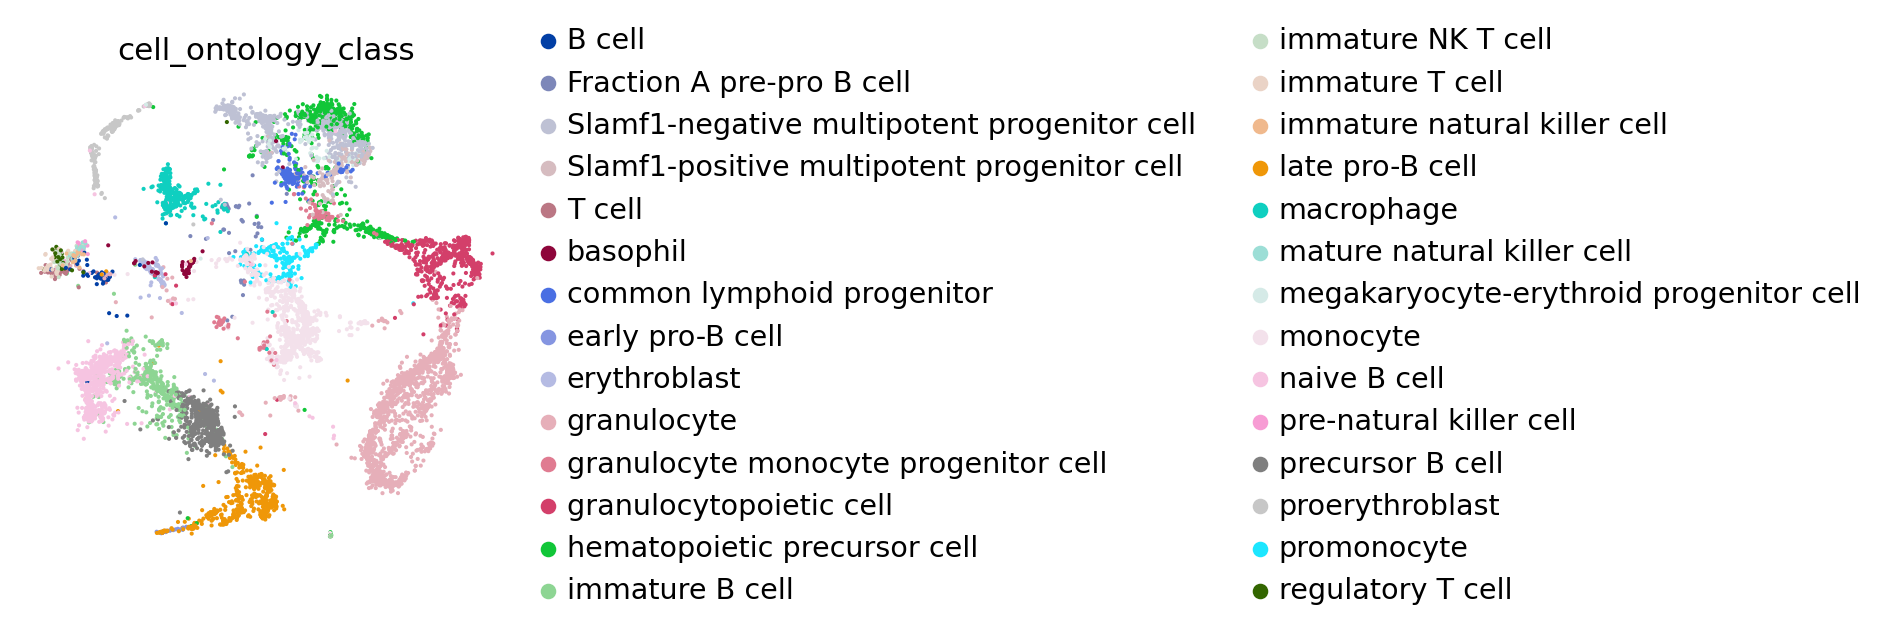

In [40]:
sc.pl.embedding(adata, color="cell_ontology_class", frameon=False, basis="X_mde")


/home/user-dnf/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


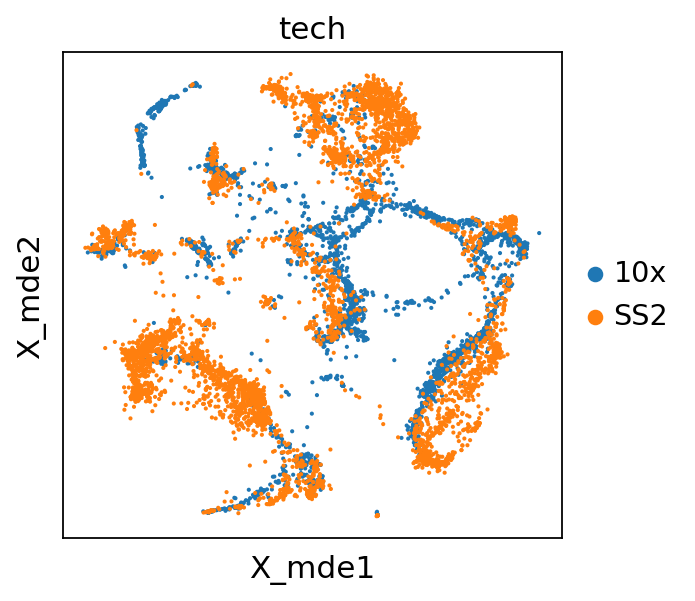

In [41]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["tech"],
    frameon=True,
    ncols=1,
)

/home/user-dnf/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


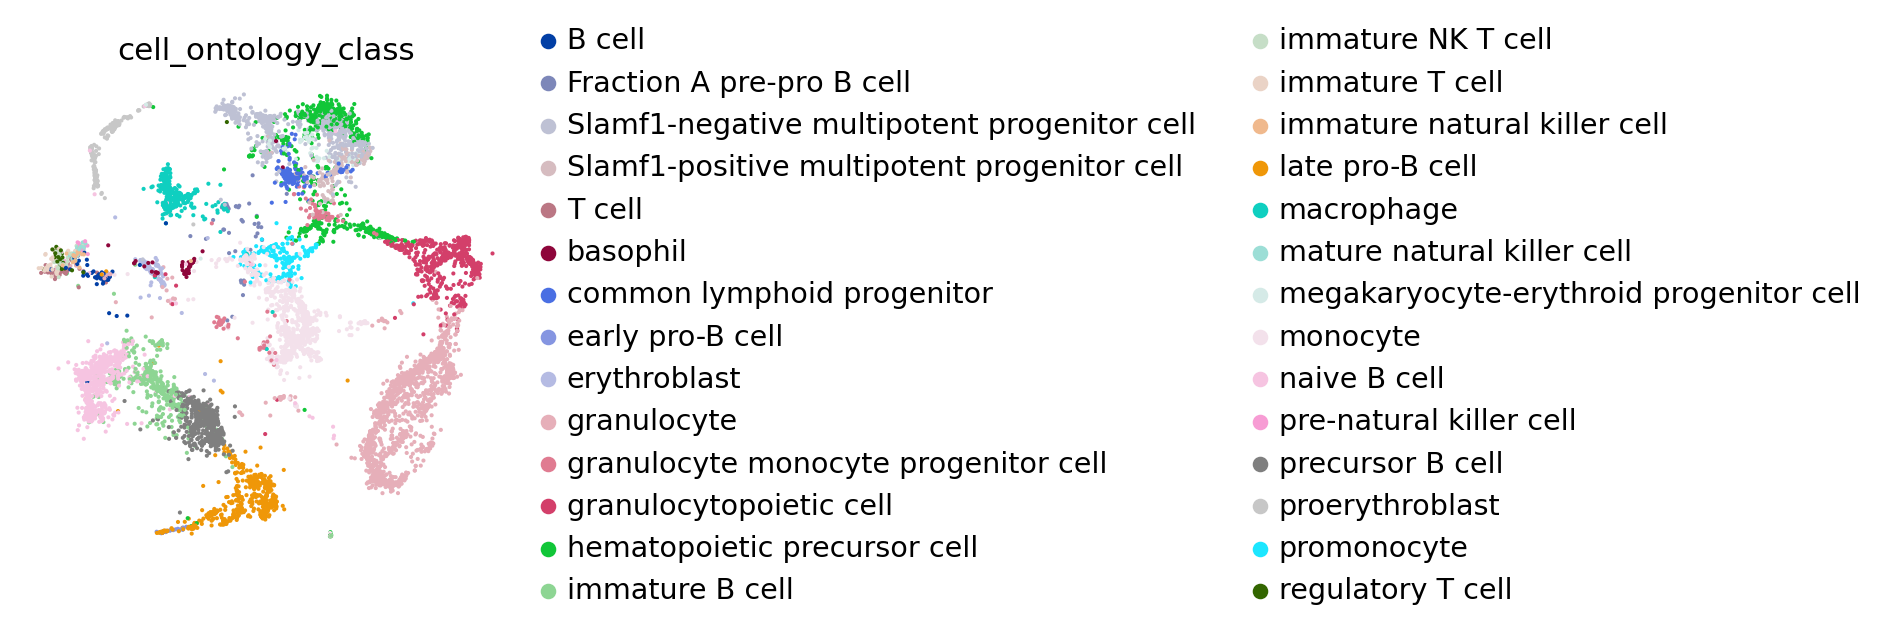

In [42]:
sc.pl.embedding(adata, color="cell_ontology_class", frameon=False, basis="X_mde")


In [43]:

### figure out how to add kl_annealing to the training scheme 